# Credit Default Model Monitoring

**Objective**: Monitor model performance and stability across time

**Monitoring Components**:
1. **Model Performance Monitoring**
   - Prediction distribution tracking
   - Default rate trends
   - Score distribution stability
   - Performance metrics over time (if labels available)

2. **Model Stability Monitoring**
   - Population Stability Index (PSI)
   - Feature drift detection
   - Data quality checks
   - Concept drift indicators

**Date**: 2025-10-26

## 1. Setup and Imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Scikit-learn imports
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score
)

# Model persistence
import joblib

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All imports successful!")
print(f"Python version: {pd.__version__}")

All imports successful!
Python version: 2.1.4


In [2]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("model_monitoring") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session initialized")
print(f"Spark version: {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 08:33:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized
Spark version: 3.5.0


## 2. Load Model Artifacts and Predictions

In [4]:
!pip install dill

In [9]:
# Load model artifacts
model_dir = '/app/models/'

print("Loading model artifacts...")

# Check if model exists
model_path = f'{model_dir}xgboost_credit_default_model.pkl'
if not os.path.exists(model_path):
    print(f"❌ Model not found at {model_path}")
    print("Please ensure model training has completed.")
else:
    model = joblib.load(model_path)
    preprocessors = joblib.load(f'{model_dir}preprocessors.pkl')
    metadata = joblib.load(f'{model_dir}model_metadata.pkl')
    feature_importance = pd.read_csv(f'{model_dir}feature_importance.csv')
    
    print("✅ Model artifacts loaded successfully!")
    print(f"\nModel metadata:")
    print(f"  Model type: {metadata['model_type']}")
    print(f"  Training date: {metadata['training_date']}")
    
    # Extract metrics from nested structure
    if 'metrics' in metadata:
        metrics = metadata['metrics']
        if 'test' in metrics and 'auc' in metrics['test']:
            print(f"  Test AUC: {metrics['test']['auc']:.4f}")
        if 'oot' in metrics and 'auc' in metrics['oot']:
            print(f"  OOT AUC: {metrics['oot']['auc']:.4f}")
    
    # Get number of features from preprocessors
    if 'feature_names' in preprocessors:
        n_features = len(preprocessors['feature_names'])
    else:
        n_features = len(feature_importance)
    print(f"  Number of features: {n_features}")

Loading model artifacts...
✅ Model artifacts loaded successfully!

Model metadata:
  Model type: XGBoost
  Training date: 2025-10-26 08:00:32.392736
  Test AUC: 0.7993
  OOT AUC: 0.8238
  Number of features: 26


In [8]:
# Load all prediction files
predictions_dir = '/app/predictions/'

print("Loading prediction files...")

# Get all prediction files
prediction_files = sorted(glob.glob(f'{predictions_dir}predictions_*.csv'))

if len(prediction_files) == 0:
    print(f"❌ No prediction files found in {predictions_dir}")
    print("Please wait for model inference to complete.")
else:
    print(f"✅ Found {len(prediction_files)} prediction files")
    
    # Load all predictions
    predictions_list = []
    for file in prediction_files:
        df = pd.read_csv(file)
        predictions_list.append(df)
    
    # Combine all predictions
    all_predictions = pd.concat(predictions_list, ignore_index=True)
    all_predictions['inference_date'] = pd.to_datetime(all_predictions['inference_date'])
    
    print(f"\nTotal predictions: {len(all_predictions):,}")
    print(f"Date range: {all_predictions['inference_date'].min()} to {all_predictions['inference_date'].max()}")
    print(f"Unique months: {all_predictions['inference_date'].nunique()}")
    
    # Show sample
    print(f"\nSample predictions:")
    print(all_predictions.head())

Loading prediction files...
✅ Found 9 prediction files

Total predictions: 4,515
Date range: 2024-05-01 00:00:00 to 2025-01-01 00:00:00
Unique months: 9

Sample predictions:
  Customer_ID inference_date  predicted_default  default_probability  \
0  CUS_0x1075     2024-05-01                  0             0.329295   
1  CUS_0x1185     2024-05-01                  1             0.742095   
2  CUS_0x1190     2024-05-01                  0             0.296679   
3  CUS_0x122f     2024-05-01                  1             0.536821   
4  CUS_0x1233     2024-05-01                  0             0.241482   

  risk_category  
0   Medium Risk  
1     High Risk  
2      Low Risk  
3   Medium Risk  
4      Low Risk  


## 3. Model Performance Monitoring

### 3.1 Monthly Prediction Statistics

In [10]:
# Calculate monthly statistics
monthly_stats = all_predictions.groupby('inference_date').agg({
    'Customer_ID': 'count',
    'default_probability': ['mean', 'std', 'min', 'max', 'median'],
    'predicted_default': 'mean'
}).reset_index()

# Flatten column names
monthly_stats.columns = ['inference_date', 'n_customers', 'avg_probability', 
                          'std_probability', 'min_probability', 'max_probability', 
                          'median_probability', 'predicted_default_rate']

# Add risk category distribution
risk_dist = all_predictions.groupby(['inference_date', 'risk_category']).size().unstack(fill_value=0)
risk_dist_pct = risk_dist.div(risk_dist.sum(axis=1), axis=0) * 100

monthly_stats = monthly_stats.merge(
    risk_dist_pct.add_prefix('pct_'),
    left_on='inference_date',
    right_index=True,
    how='left'
)

print("="*100)
print("MONTHLY PREDICTION STATISTICS")
print("="*100)
print(monthly_stats.to_string(index=False))

MONTHLY PREDICTION STATISTICS
inference_date  n_customers  avg_probability  std_probability  min_probability  max_probability  median_probability  predicted_default_rate  pct_High Risk  pct_Low Risk  pct_Medium Risk
    2024-05-01          491         0.425200         0.246353         0.048197         0.890909            0.315476                0.342159      22.403259     47.454175        30.142566
    2024-06-01          498         0.407327         0.234384         0.046071         0.891210            0.315594                0.317269      17.469880     45.582329        36.947791
    2024-07-01          505         0.406725         0.224769         0.047533         0.829271            0.322510                0.344554      15.643564     46.138614        38.217822
    2024-08-01          543         0.403692         0.211849         0.044460         0.827941            0.320590                0.307551      15.469613     45.119705        39.410681
    2024-09-01          493         0.40

### 3.2 Trend Analysis Over Time

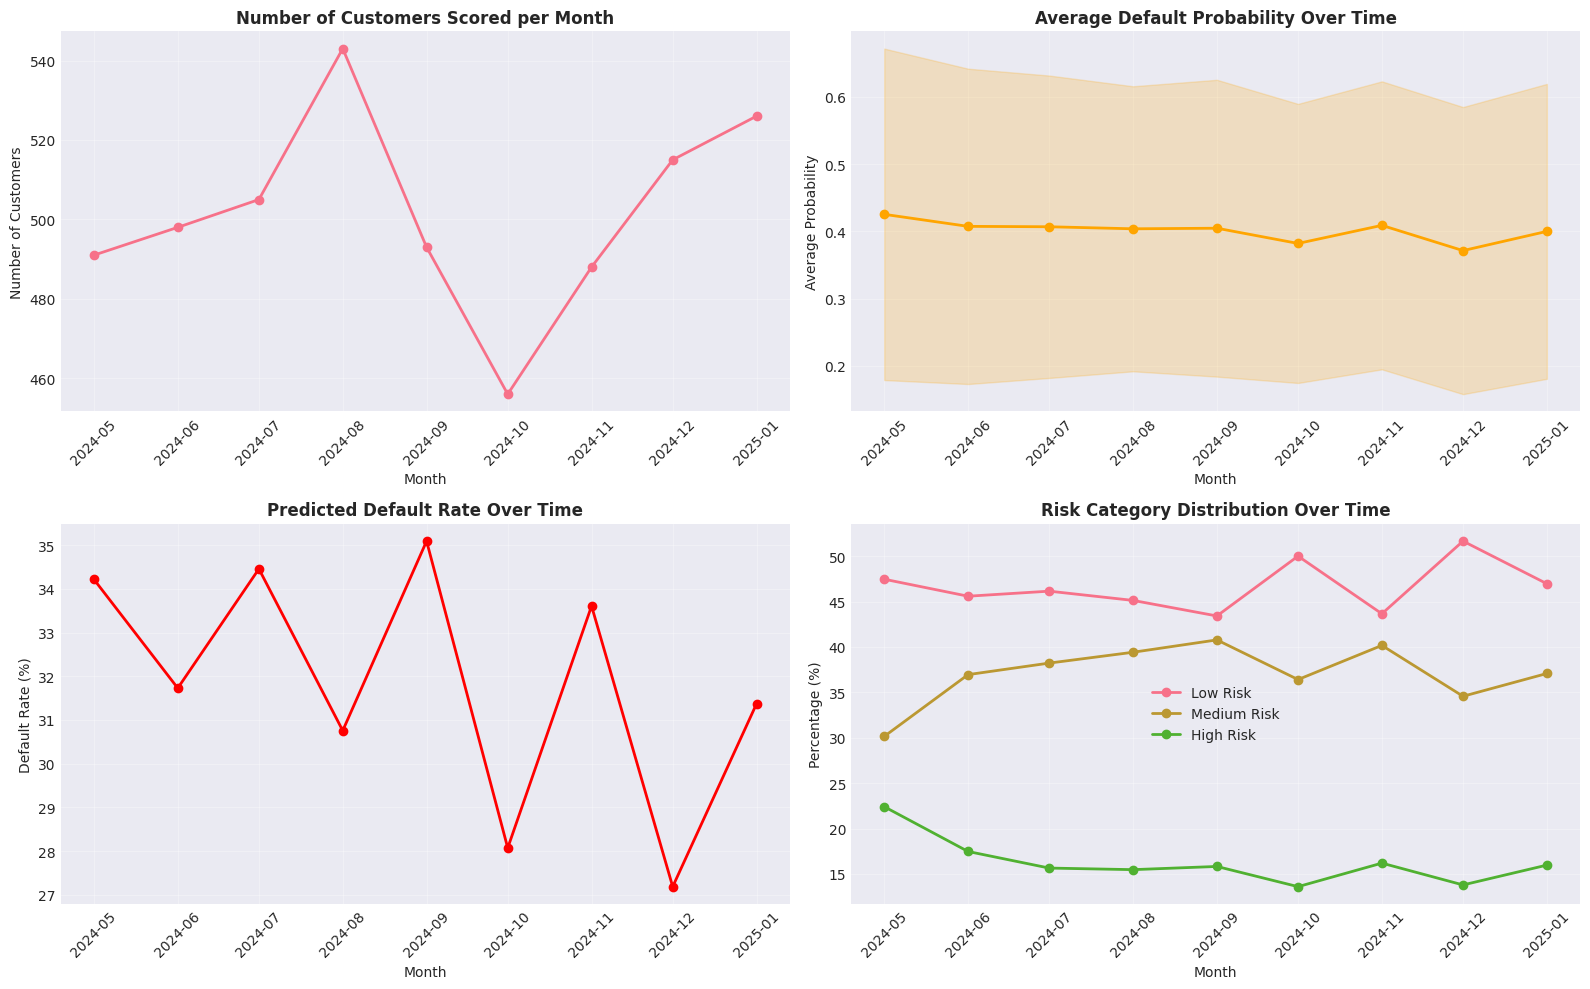


✅ Performance trends visualized


In [11]:
# Plot key metrics over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Number of customers scored
axes[0, 0].plot(monthly_stats['inference_date'], monthly_stats['n_customers'], 
                marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Number of Customers Scored per Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average default probability
axes[0, 1].plot(monthly_stats['inference_date'], monthly_stats['avg_probability'], 
                marker='o', linewidth=2, markersize=6, color='orange')
axes[0, 1].fill_between(monthly_stats['inference_date'], 
                         monthly_stats['avg_probability'] - monthly_stats['std_probability'],
                         monthly_stats['avg_probability'] + monthly_stats['std_probability'],
                         alpha=0.2, color='orange')
axes[0, 1].set_title('Average Default Probability Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Probability')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Predicted default rate
axes[1, 0].plot(monthly_stats['inference_date'], monthly_stats['predicted_default_rate'] * 100, 
                marker='o', linewidth=2, markersize=6, color='red')
axes[1, 0].set_title('Predicted Default Rate Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Default Rate (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Risk category distribution
for col in ['pct_Low Risk', 'pct_Medium Risk', 'pct_High Risk']:
    if col in monthly_stats.columns:
        axes[1, 1].plot(monthly_stats['inference_date'], monthly_stats[col], 
                       marker='o', linewidth=2, markersize=6, label=col.replace('pct_', ''))
axes[1, 1].set_title('Risk Category Distribution Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Performance trends visualized")

### 3.3 Score Distribution Analysis

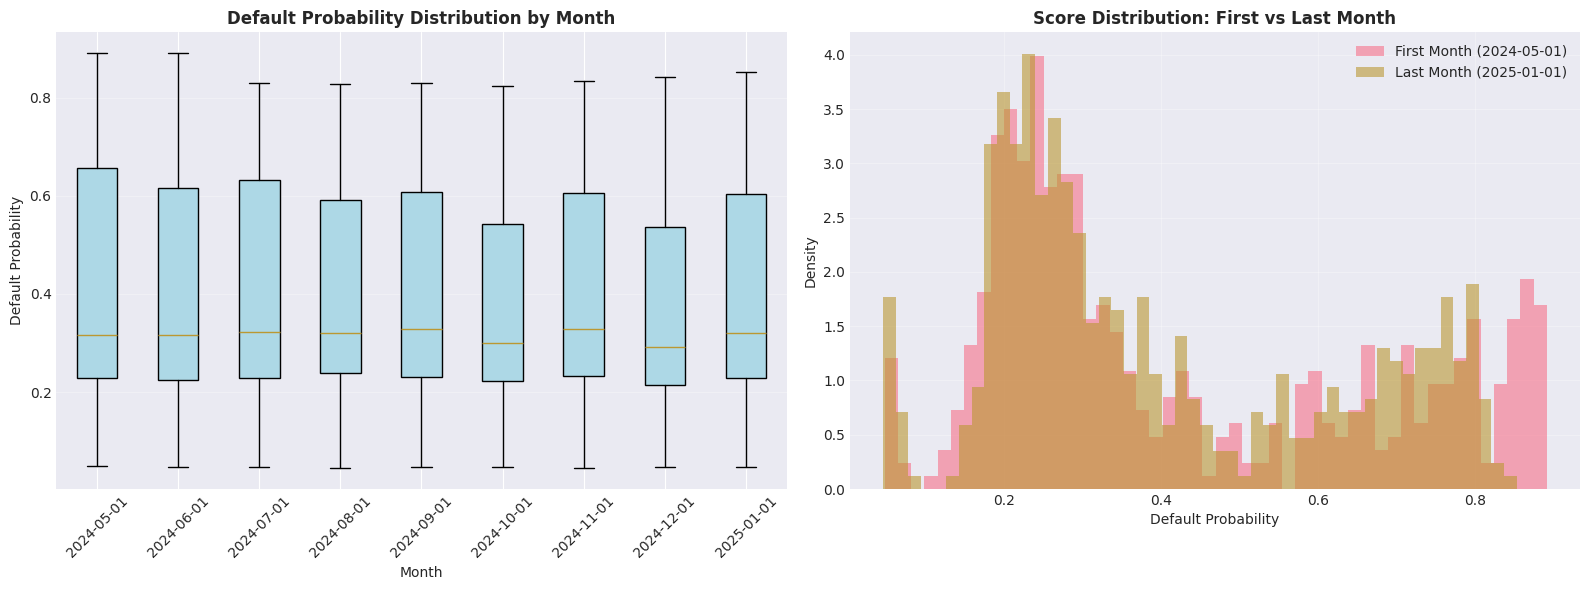


✅ Score distribution visualized


In [12]:
# Plot score distribution over time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Box plot of default probabilities by month
months_for_boxplot = sorted(all_predictions['inference_date'].unique())
data_for_boxplot = [all_predictions[all_predictions['inference_date'] == month]['default_probability'].values 
                    for month in months_for_boxplot]

bp = axes[0].boxplot(data_for_boxplot, labels=[str(m.date()) for m in months_for_boxplot], 
                     patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_title('Default Probability Distribution by Month', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Default Probability')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Distribution comparison (first vs last month)
first_month = sorted(all_predictions['inference_date'].unique())[0]
last_month = sorted(all_predictions['inference_date'].unique())[-1]

axes[1].hist(all_predictions[all_predictions['inference_date'] == first_month]['default_probability'], 
             bins=50, alpha=0.6, label=f'First Month ({first_month.date()})', density=True)
axes[1].hist(all_predictions[all_predictions['inference_date'] == last_month]['default_probability'], 
             bins=50, alpha=0.6, label=f'Last Month ({last_month.date()})', density=True)
axes[1].set_title('Score Distribution: First vs Last Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Default Probability')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Score distribution visualized")

### 3.4 Model Evaluation Metrics (with Actual Labels)

**Key Performance Metrics**:
- **AUC-ROC**: Ability to distinguish between default and non-default
- **Precision**: Of predicted defaults, how many actually defaulted
- **Recall**: Of actual defaults, how many did we catch  
- **F1-Score**: Harmonic mean of precision and recall
- **Accuracy**: Overall correctness

**Business Impact Metrics**:
- **Expected Loss**: Financial impact of false negatives
- **Approval Rate**: Percentage of loans approved
- **Default Capture Rate**: Percentage of actual defaults flagged

## 4. Model Stability Monitoring

### 4.1 Population Stability Index (PSI)

In [13]:
# PSI calculation function
def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index (PSI)
    
    PSI Interpretation:
    - PSI < 0.1: No significant change
    - 0.1 <= PSI < 0.2: Moderate change, investigate
    - PSI >= 0.2: Significant change, model may need retraining
    """
    # Create bins based on expected distribution
    breakpoints = np.linspace(0, 1, bins + 1)
    
    # Calculate distributions
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    # Avoid division by zero
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Calculate PSI
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)
    
    return psi, breakpoints, expected_percents, actual_percents

# Use first month as baseline
baseline_month = sorted(all_predictions['inference_date'].unique())[0]
baseline_scores = all_predictions[all_predictions['inference_date'] == baseline_month]['default_probability'].values

# Calculate PSI for each subsequent month
psi_results = []

for month in sorted(all_predictions['inference_date'].unique())[1:]:
    month_scores = all_predictions[all_predictions['inference_date'] == month]['default_probability'].values
    psi, _, _, _ = calculate_psi(baseline_scores, month_scores)
    
    psi_results.append({
        'month': month,
        'psi': psi
    })

psi_df = pd.DataFrame(psi_results)

print("="*80)
print("POPULATION STABILITY INDEX (PSI)")
print("="*80)
print(f"Baseline month: {baseline_month.date()}")
print(f"\nPSI Interpretation:")
print(f"  PSI < 0.1: No significant change")
print(f"  0.1 <= PSI < 0.2: Moderate change")
print(f"  PSI >= 0.2: Significant change (model retraining recommended)")
print(f"\nPSI by Month:")
print(psi_df.to_string(index=False))

POPULATION STABILITY INDEX (PSI)
Baseline month: 2024-05-01

PSI Interpretation:
  PSI < 0.1: No significant change
  0.1 <= PSI < 0.2: Moderate change
  PSI >= 0.2: Significant change (model retraining recommended)

PSI by Month:
     month      psi
2024-06-01 0.054969
2024-07-01 0.166303
2024-08-01 0.174791
2024-09-01 0.394067
2024-10-01 0.212630
2024-11-01 0.221669
2024-12-01 0.371387
2025-01-01 0.172102


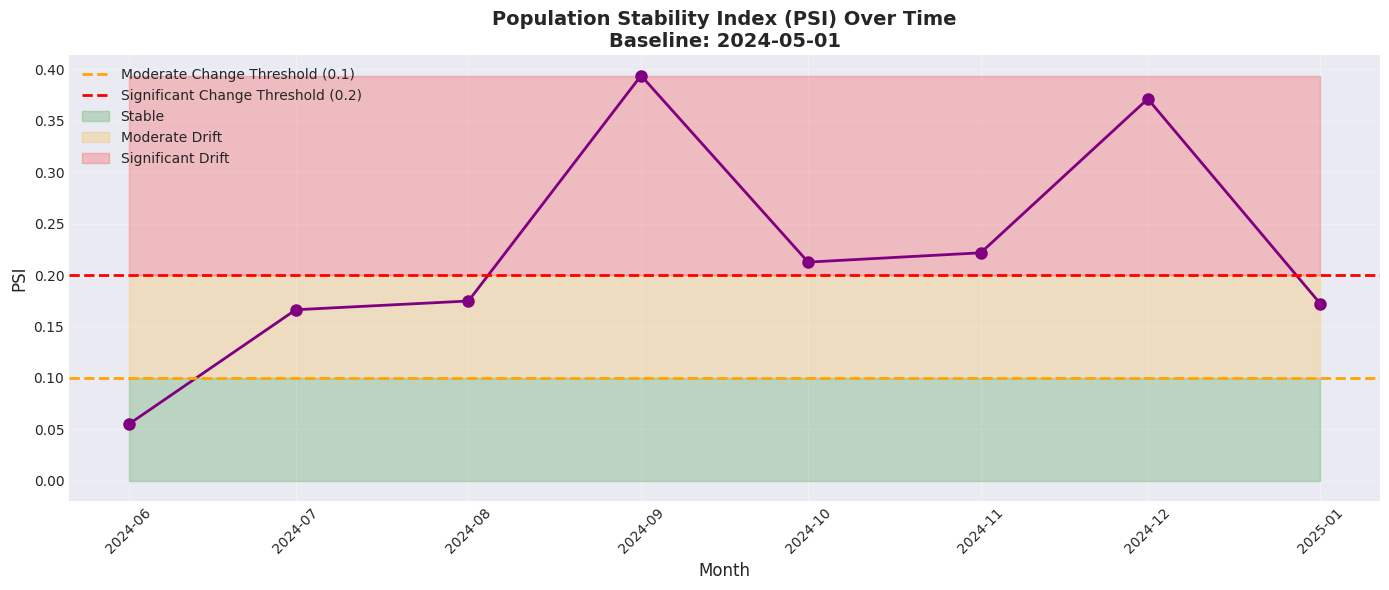


⚠️  WARNING: Significant population drift detected!
Months with PSI >= 0.2:
     month      psi
2024-09-01 0.394067
2024-10-01 0.212630
2024-11-01 0.221669
2024-12-01 0.371387

Recommendation: Model retraining is recommended


In [14]:
# Plot PSI over time
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(psi_df['month'], psi_df['psi'], marker='o', linewidth=2, markersize=8, color='purple')

# Add threshold lines
ax.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Moderate Change Threshold (0.1)')
ax.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Significant Change Threshold (0.2)')

# Color areas
ax.fill_between(psi_df['month'], 0, 0.1, alpha=0.2, color='green', label='Stable')
ax.fill_between(psi_df['month'], 0.1, 0.2, alpha=0.2, color='orange', label='Moderate Drift')
ax.fill_between(psi_df['month'], 0.2, psi_df['psi'].max() if psi_df['psi'].max() > 0.2 else 0.3, 
                alpha=0.2, color='red', label='Significant Drift')

ax.set_title(f'Population Stability Index (PSI) Over Time\nBaseline: {baseline_month.date()}', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('PSI', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check for concerning PSI values
moderate_drift = psi_df[psi_df['psi'] >= 0.1]
significant_drift = psi_df[psi_df['psi'] >= 0.2]

if len(significant_drift) > 0:
    print("\n⚠️  WARNING: Significant population drift detected!")
    print("Months with PSI >= 0.2:")
    print(significant_drift.to_string(index=False))
    print("\nRecommendation: Model retraining is recommended")
elif len(moderate_drift) > 0:
    print("\n⚠️  CAUTION: Moderate population drift detected")
    print("Months with PSI >= 0.1:")
    print(moderate_drift.to_string(index=False))
    print("\nRecommendation: Monitor closely, investigate root causes")
else:
    print("\n✅ No significant population drift detected. Model is stable.")

### 4.2 Feature Drift Detection

In [15]:
# Load feature store to analyze feature drift
print("Loading feature store for drift analysis...")

feature_path = '/app/datamart/gold/feature_store/'

# Load all feature store files
feature_files = sorted(glob.glob(f'{feature_path}*.parquet'))

if len(feature_files) > 0:
    # Read all feature files
    df_features = spark.read.parquet(f'{feature_path}*.parquet').toPandas()
    df_features['snapshot_date'] = pd.to_datetime(df_features['snapshot_date'])
    
    print(f"✅ Feature store loaded: {len(df_features):,} rows")
    print(f"Date range: {df_features['snapshot_date'].min()} to {df_features['snapshot_date'].max()}")
else:
    print("❌ No feature store files found")

Loading feature store for drift analysis...


✅ Feature store loaded: 12,500 rows
Date range: 2023-01-01 00:00:00 to 2025-01-01 00:00:00


In [16]:
# Calculate feature drift for top features
top_features = feature_importance.head(10)['feature'].tolist()

# Select numeric features only
numeric_top_features = [f for f in top_features if f in df_features.select_dtypes(include=[np.number]).columns]

print(f"Analyzing drift for top {len(numeric_top_features)} numeric features...")
print(f"Features: {numeric_top_features}")

# Calculate feature statistics by month
feature_drift_results = []

baseline_month_features = df_features['snapshot_date'].min()
baseline_data = df_features[df_features['snapshot_date'] == baseline_month_features]

for month in sorted(df_features['snapshot_date'].unique())[1:]:
    month_data = df_features[df_features['snapshot_date'] == month]
    
    for feature in numeric_top_features:
        if feature in month_data.columns and feature in baseline_data.columns:
            # Calculate PSI for this feature
            baseline_values = baseline_data[feature].dropna().values
            month_values = month_data[feature].dropna().values
            
            if len(baseline_values) > 0 and len(month_values) > 0:
                psi, _, _, _ = calculate_psi(baseline_values, month_values)
                
                # Calculate mean and std change
                mean_baseline = baseline_values.mean()
                mean_month = month_values.mean()
                mean_change_pct = ((mean_month - mean_baseline) / (abs(mean_baseline) + 1e-10)) * 100
                
                std_baseline = baseline_values.std()
                std_month = month_values.std()
                std_change_pct = ((std_month - std_baseline) / (abs(std_baseline) + 1e-10)) * 100
                
                feature_drift_results.append({
                    'month': month,
                    'feature': feature,
                    'psi': psi,
                    'mean_change_pct': mean_change_pct,
                    'std_change_pct': std_change_pct
                })

feature_drift_df = pd.DataFrame(feature_drift_results)

print(f"\n✅ Feature drift calculated for {len(feature_drift_df)} feature-month combinations")

Analyzing drift for top 8 numeric features...
Features: ['Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Card', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Debt_to_income_ratio']

✅ Feature drift calculated for 192 feature-month combinations


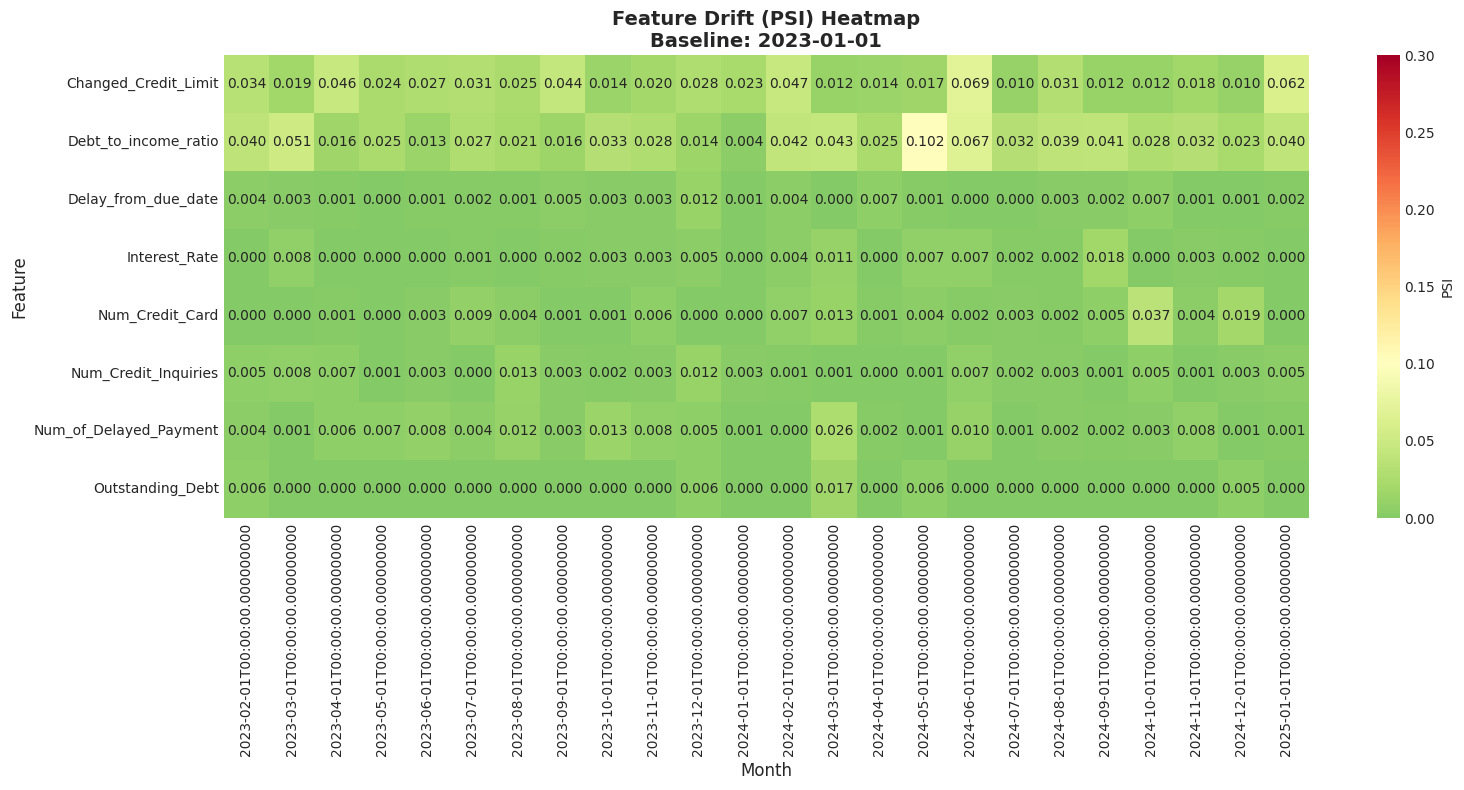


✅ No significant feature drift detected


In [17]:
# Plot feature drift heatmap
if len(feature_drift_df) > 0:
    # Create pivot table for heatmap
    psi_pivot = feature_drift_df.pivot(index='feature', columns='month', values='psi')
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(16, 8))
    
    sns.heatmap(psi_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r', 
                center=0.1, vmin=0, vmax=0.3, ax=ax, cbar_kws={'label': 'PSI'})
    
    ax.set_title(f'Feature Drift (PSI) Heatmap\nBaseline: {baseline_month_features.date()}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Identify features with high drift
    high_drift_features = feature_drift_df[feature_drift_df['psi'] >= 0.2]
    
    if len(high_drift_features) > 0:
        print("\n⚠️  WARNING: Features with significant drift (PSI >= 0.2):")
        print(high_drift_features[['month', 'feature', 'psi']].to_string(index=False))
    else:
        print("\n✅ No significant feature drift detected")

### 4.3 Data Quality Monitoring

In [18]:
# Monitor data quality metrics over time
data_quality_results = []

for month in sorted(df_features['snapshot_date'].unique()):
    month_data = df_features[df_features['snapshot_date'] == month]
    
    # Calculate quality metrics
    n_rows = len(month_data)
    n_features = len(month_data.columns) - 2  # Exclude Customer_ID and snapshot_date
    
    # Missing value rate
    missing_rate = month_data.isnull().sum().sum() / (n_rows * n_features) * 100
    
    # Number of duplicates
    n_duplicates = month_data.duplicated(subset=['Customer_ID']).sum()
    
    data_quality_results.append({
        'month': month,
        'n_rows': n_rows,
        'missing_rate_pct': missing_rate,
        'n_duplicates': n_duplicates
    })

data_quality_df = pd.DataFrame(data_quality_results)

print("="*80)
print("DATA QUALITY METRICS")
print("="*80)
print(data_quality_df.to_string(index=False))

DATA QUALITY METRICS
     month  n_rows  missing_rate_pct  n_duplicates
2023-01-01     530         20.411051             0
2023-02-01     501          2.502139             0
2023-03-01     506          2.632693             0
2023-04-01     510          2.549020             0
2023-05-01     521          2.406087             0
2023-06-01     517          2.314175             0
2023-07-01     471          2.327874             0
2023-08-01     481          2.398277             0
2023-09-01     454          2.572373             0
2023-10-01     487          2.427398             0
2023-11-01     491          2.254873             0
2023-12-01     489          2.205668             0
2024-01-01     485          2.430044             0
2024-02-01     518          2.289024             0
2024-03-01     511          2.355326             0
2024-04-01     513          2.457533             0
2024-05-01     491          2.414897             0
2024-06-01     498          2.588927             0
2024-07-01

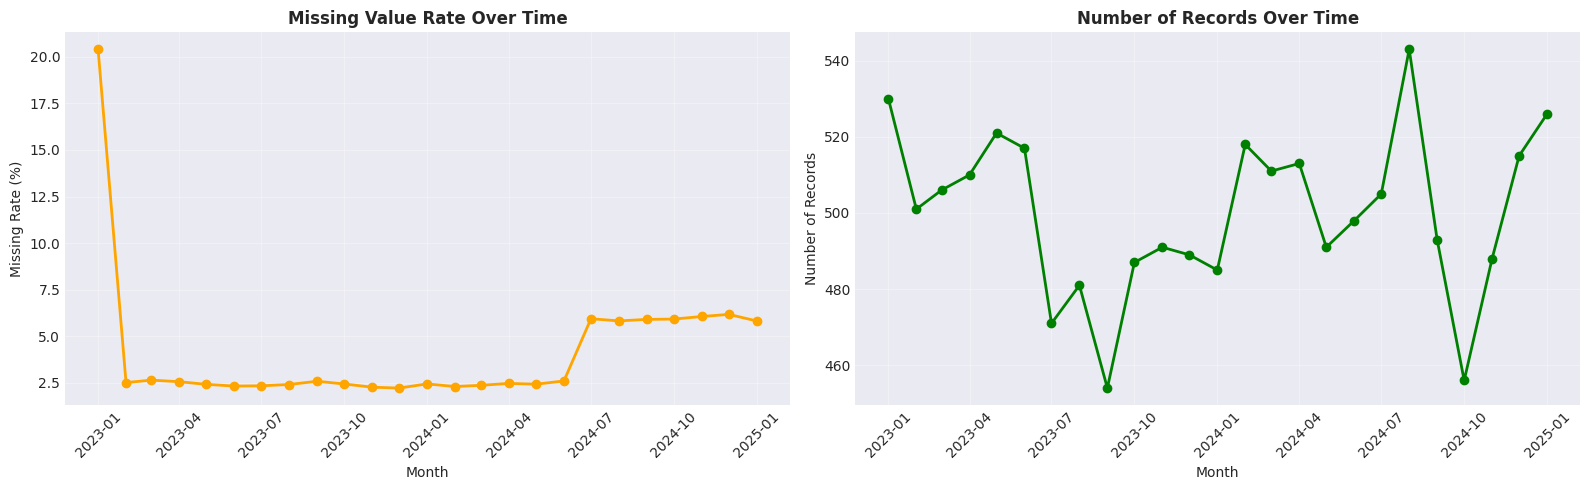


✅ Data quality monitoring complete


In [19]:
# Plot data quality trends
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Missing value rate
axes[0].plot(data_quality_df['month'], data_quality_df['missing_rate_pct'], 
            marker='o', linewidth=2, markersize=6, color='orange')
axes[0].set_title('Missing Value Rate Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Missing Rate (%)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Number of rows
axes[1].plot(data_quality_df['month'], data_quality_df['n_rows'], 
            marker='o', linewidth=2, markersize=6, color='green')
axes[1].set_title('Number of Records Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Records')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Data quality monitoring complete")

## 5. Monitoring Summary and Recommendations

In [20]:
# Generate monitoring summary report
print("\n" + "="*100)
print("MODEL MONITORING SUMMARY REPORT")
print("="*100)

print(f"\nReport Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Model Training Date: {metadata['training_date']}")
print(f"Monitoring Period: {all_predictions['inference_date'].min().date()} to {all_predictions['inference_date'].max().date()}")
print(f"Total Months Monitored: {len(all_predictions['inference_date'].unique())}")

print("\n1. MODEL PERFORMANCE SUMMARY")
print("-" * 100)
print(f"Total Customers Scored: {len(all_predictions):,}")
print(f"Average Default Probability: {all_predictions['default_probability'].mean():.4f}")
print(f"Overall Predicted Default Rate: {all_predictions['predicted_default'].mean()*100:.2f}%")

print("Risk Category Distribution:")
risk_dist_overall = all_predictions['risk_category'].value_counts(normalize=True) * 100
for category, pct in risk_dist_overall.items():
    print(f"  {category}: {pct:.2f}%")

print("\n2. POPULATION STABILITY (PSI)")
print("-" * 100)
print(f"Baseline Month: {baseline_month.date()}")
print(f"Average PSI: {psi_df['psi'].mean():.4f}")
print(f"Max PSI: {psi_df['psi'].max():.4f} (on {psi_df.loc[psi_df['psi'].idxmax(), 'month'].date()})")
print(f"Min PSI: {psi_df['psi'].min():.4f} (on {psi_df.loc[psi_df['psi'].idxmin(), 'month'].date()})")

n_stable = (psi_df['psi'] < 0.1).sum()
n_moderate = ((psi_df['psi'] >= 0.1) & (psi_df['psi'] < 0.2)).sum()
n_significant = (psi_df['psi'] >= 0.2).sum()

print(f"\nStability Classification:")
print(f"  Stable (PSI < 0.1): {n_stable} months")
print(f"  Moderate Drift (0.1 <= PSI < 0.2): {n_moderate} months")
print(f"  Significant Drift (PSI >= 0.2): {n_significant} months")

print("\n3. FEATURE DRIFT")
print("-" * 100)
if len(feature_drift_df) > 0:
    avg_feature_psi = feature_drift_df.groupby('feature')['psi'].mean().sort_values(ascending=False)
    print(f"Top 5 Features with Highest Average PSI:")
    for feature, psi in avg_feature_psi.head(5).items():
        print(f"  {feature}: {psi:.4f}")
    
    n_features_high_drift = len(feature_drift_df[feature_drift_df['psi'] >= 0.2]['feature'].unique())
    print(f"\nFeatures with significant drift (PSI >= 0.2): {n_features_high_drift}")

print("\n4. DATA QUALITY")
print("-" * 100)
print(f"Average Missing Value Rate: {data_quality_df['missing_rate_pct'].mean():.2f}%")
print(f"Max Missing Value Rate: {data_quality_df['missing_rate_pct'].max():.2f}% (on {data_quality_df.loc[data_quality_df['missing_rate_pct'].idxmax(), 'month'].date()})")
print(f"Average Records per Month: {data_quality_df['n_rows'].mean():.0f}")

print("\n5. RECOMMENDATIONS")
print("-" * 100)

recommendations = []

# Check PSI
if n_significant > 0:
    recommendations.append("CRITICAL: Significant population drift detected. Model retraining is strongly recommended.")
elif n_moderate > 0:
    recommendations.append("CAUTION: Moderate population drift detected. Continue monitoring and investigate root causes.")
else:
    recommendations.append("Population is stable. No immediate action required.")

# Check feature drift
if len(feature_drift_df) > 0:
    if n_features_high_drift > 0:
        recommendations.append(f"CRITICAL: {n_features_high_drift} features showing significant drift. Investigate feature changes.")

# Check data quality
if data_quality_df['missing_rate_pct'].max() > 5:
    recommendations.append("CAUTION: Missing value rate exceeds 5% in some months. Review data pipeline.")

# Check performance trends
if monthly_stats['predicted_default_rate'].std() > 0.05:
    recommendations.append("CAUTION: High variability in predicted default rates. Investigate potential data quality issues.")

# General recommendations
recommendations.append("Continue monitoring model performance monthly.")
recommendations.append("Set up automated alerts for PSI > 0.2 or feature drift > 0.2.")
recommendations.append("Schedule quarterly model performance reviews.")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*100)
print("END OF MONITORING REPORT")
print("="*100)


MODEL MONITORING SUMMARY REPORT

Report Date: 2025-10-26 08:41:08
Model Training Date: 2025-10-26 08:00:32.392736
Monitoring Period: 2024-05-01 to 2025-01-01
Total Months Monitored: 9

1. MODEL PERFORMANCE SUMMARY
----------------------------------------------------------------------------------------------------
Total Customers Scored: 4,515
Average Default Probability: 0.4011
Overall Predicted Default Rate: 31.83%
Risk Category Distribution:
  Low Risk: 46.64%
  Medium Risk: 37.10%
  High Risk: 16.26%

2. POPULATION STABILITY (PSI)
----------------------------------------------------------------------------------------------------
Baseline Month: 2024-05-01
Average PSI: 0.2210
Max PSI: 0.3941 (on 2024-09-01)
Min PSI: 0.0550 (on 2024-06-01)

Stability Classification:
  Stable (PSI < 0.1): 1 months
  Moderate Drift (0.1 <= PSI < 0.2): 3 months
  Significant Drift (PSI >= 0.2): 4 months

3. FEATURE DRIFT
----------------------------------------------------------------------------------

## 6. Save Monitoring Results

In [21]:
# Save monitoring results
import os
os.makedirs('/app/monitoring_reports', exist_ok=True)

# Save PSI results
psi_df.to_csv('/app/monitoring_reports/psi_results.csv', index=False)
print("PSI results saved to: /app/monitoring_reports/psi_results.csv")

# Save monthly statistics
monthly_stats.to_csv('/app/monitoring_reports/monthly_statistics.csv', index=False)
print("Monthly statistics saved to: /app/monitoring_reports/monthly_statistics.csv")

# Save feature drift results
if len(feature_drift_df) > 0:
    feature_drift_df.to_csv('/app/monitoring_reports/feature_drift_results.csv', index=False)
    print("Feature drift results saved to: /app/monitoring_reports/feature_drift_results.csv")

# Save data quality results
data_quality_df.to_csv('/app/monitoring_reports/data_quality_metrics.csv', index=False)
print("Data quality metrics saved to: /app/monitoring_reports/data_quality_metrics.csv")

print("\n✅ All monitoring results saved successfully!")

PSI results saved to: /app/monitoring_reports/psi_results.csv
Monthly statistics saved to: /app/monitoring_reports/monthly_statistics.csv
Feature drift results saved to: /app/monitoring_reports/feature_drift_results.csv
Data quality metrics saved to: /app/monitoring_reports/data_quality_metrics.csv

✅ All monitoring results saved successfully!


In [ ]:
# Clean up Spark session
spark.stop()
print("Spark session stopped.")